# We use the GH statuses to find the time on which Circle was adopted

In [1]:
from pymongo import MongoClient

mongo_client = MongoClient()
database = mongo_client["graduation"]
pull_requests_collection = database["pull_requests"]
projects_collection = database["projects"]
commits_collection = database["commits"]

In [2]:
from urllib.parse import urlparse

import datetime

scraped_projects = list(projects_collection.find({'succeeded': True, 
                                                  'travis_is_oldest_ci': {'$exists':False}, 
                                                  'circle_is_oldest_ci': {'$exists': False}, 
                                                  'scrape_type':'icse_1'}))
print("Analyzing {}".format(len(scraped_projects)))

for project in scraped_projects:
    print("-----------------------------------------")
    print("Starting {}".format(project["full_name"]))
    
    pull_requests = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],
                                                       'project_owner': project["full_name"].split("/")[0]},
                                                      {'commits':1, 'raw_comments':1, 'created_at': 1}))
    
    sha_list = list([commit for pr in pull_requests for commit in pr["commits"]])
        
    commits = [commits_collection.find_one({'sha': sha_hash}) for sha_hash in sha_list]
    
    statuses = list([status for commit in commits for status in commit["statuses"]])
    
    print("{} commits, and {} statuses".format(len(commits), len(statuses)))
    
    if len(statuses) == 0:
        # this is pointless, update and continue
        project["status_circle_date"] = None
        project["circle_is_oldest_ci"] = False
        
        projects_collection.replace_one({"full_name" : project["full_name"]}, project)
        
        continue
    
    print("Oldest reported status is: {}".format(min([status["created_at"] for status in statuses])))
    
    all_urls = [status["target_url"] for status in statuses]
    
    hostnames = list(set([urlparse(url).hostname for url in all_urls if urlparse(url).hostname is not None]))
    
    print("Total of {} unique hostnames".format(len(hostnames)))
    
    print("Hostnames are: {}".format(", ".join(hostnames)))
    
    circle_statuses = list([status["created_at"] for status in statuses if urlparse(status["target_url"]).hostname == "circleci.com"])
    
    if len(circle_statuses) == 0:
        # this is pointless, update and continue
        project["status_circle_date"] = None
        project["circle_is_oldest_ci"] = False
        
        projects_collection.replace_one({"full_name" : project["full_name"]}, project)
        
        continue
    
    oldest_circle_date = min(circle_statuses)
    
    oldest_status_date = min([status["created_at"] for status in statuses])
    
    print("Oldest circle status is: {}. While oldest status date is {}".format(oldest_circle_date, oldest_status_date))
    
    # We not only need the oldest status date for Travis, we also need the date of
    # the first occurence of the TravisBot in all its glory
    
    travis_bot_pr_dates = list([pr["created_at"] for pr in pull_requests if any([cmmnt for cmmnt in pr["raw_comments"] if cmmnt["user"]["login"] == 'travisbot'])])
    
    if len(travis_bot_pr_dates) == 0:
        travisbot_oldest_date = None
    else:
        travisbot_oldest_date = min(travis_bot_pr_dates)
        
    print("I found an old comment from the travis bot from {}".format(travisbot_oldest_date))
        
    if (travisbot_oldest_date is None or travisbot_oldest_date > oldest_circle_date) and \
    (oldest_circle_date - oldest_status_date).days < 15:
        project["status_circle_date"] = oldest_circle_date
        project["circle_is_oldest_ci"] = True
    else:
        project["status_circle_date"] = oldest_circle_date
        project["circle_is_oldest_ci"] = False
    
        
  
    
    projects_collection.replace_one({"full_name" : project["full_name"]}, project)
    

Analyzing 0


# How many PRs do the circle projects have

<Figure size 432x288 with 0 Axes>

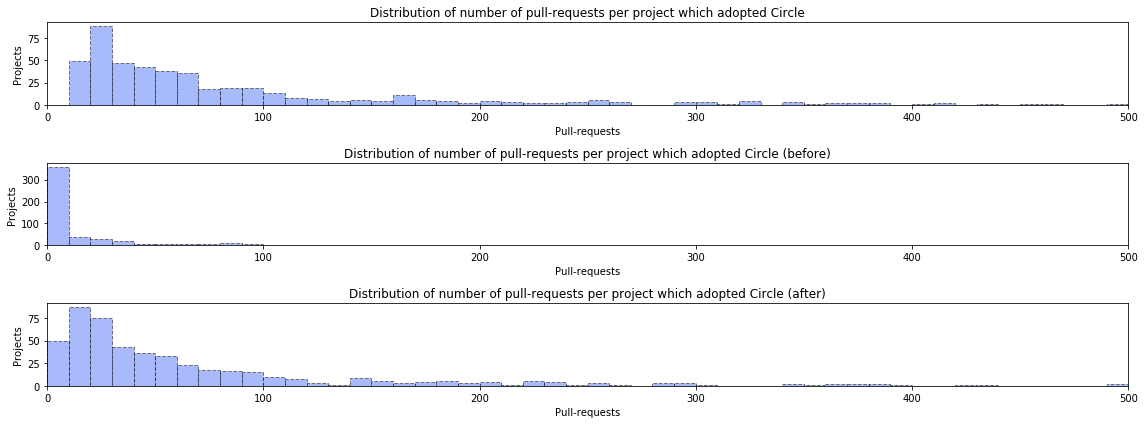

In [9]:
import analysis_utilities
import matplotlib.pyplot as plt

circle_projects = list(projects_collection.find({'succeeded': True, 
                                                  'circle_is_oldest_ci': True, 
                                                  'scrape_type':'icse_1'}))
nr_prs = []
nr_prs_before = []
nr_prs_after = []

for project in circle_projects:
    
    project_slug_split = project["full_name"].split("/")
    
    project_name = project_slug_split[1]
    project_owner = project_slug_split[0]
    
    nr_prs.append(pull_requests_collection.count_documents({'project_name': project_name, 'project_owner': project_owner}))
    
    prs_list = list(pull_requests_collection.find({'project_name': project_name, 'project_owner': project_owner}, {'created_at': 1}))
    
    (prs_before, prs_after) = analysis_utilities.split_prs_on_build_date(project, prs_list, field_name="status_circle_date")
    
    nr_prs_before.append(len(prs_before))
    nr_prs_after.append(len(prs_after))
    
    
fig = plt.figure()
    
fig = plt.figure(figsize=(16, 6))

ax = plt.subplot(3, 1, 1)

plt.hist(nr_prs, bins = 50, color='#5177f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

ax = plt.subplot(3, 1, 2)

plt.hist(nr_prs_before, bins = 50, color='#5277f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle (before)")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

ax = plt.subplot(3, 1, 3)

plt.hist(nr_prs_after, bins = 50, color='#5277f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle (after)")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

plt.tight_layout()

plt.show()